<a href="https://colab.research.google.com/github/Tarasila/Mask_RCNN_defect_detection/blob/master/Mask_RCNN_defect_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# download files to Google Drive
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

weights_file = drive.CreateFile({'title' : 'weights_16_05.h5'})
weights_file.SetContentFile('/logs/dimple20190516T1413/mask_rcnn_dimple_0005.h5')
weights_file.Upload()

drive.CreateFile({'id': weights_file.get('id')})


GoogleDriveFile({'id': '1pasebe-ZxEd30vj-JcTm-nLT4o7CsNPZ'})

In [0]:
# clone project to Colaboratory
!git clone https://github.com/Tarasila/Mask_RCNN_defect_detection.git

In [0]:
import os
import sys
import shutil

from google.colab import drive
drive.mount('/content/gdrive')

GitHub essentials

In [0]:
# copy essential folders to local environment
# - dataset
# - weights
os.chdir('Mask_RCNN_defect_detection')

!cp -r '/content/gdrive/My Drive/dataset' dataset
!cp -r '/content/gdrive/My Drive/weights' weights


In [0]:
# install all requirements
!pip install -q PyDrive
!pip install -r requirements.txt
!python setup.py install

In [5]:
!python dimple.py train --dataset=dataset/ --weights=weights/weights_16_05.h5

Using TensorFlow backend.
Weights:  weights/weights_16_05.h5
Dataset:  dataset/
Logs:  /logs

Configurations:
AUGMENT                        True
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
CROP                           True
CROP_SHAPE                     [256 256   3]
DETECTION_MASK_THRESHOLD       0.35
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.75
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0

In [7]:
import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import glob
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import dimple

# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

custom_WEIGHTS_PATH = sorted(glob.glob("/logs/*/mask_rcnn_*.h5"))[-1]
#custom_WEIGHTS_PATH = '/weights/weights_15_05.h5'

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

config = dimple.DimpleConfig()
custom_DIR = os.path.join(ROOT_DIR, "dataset")

class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
  
# Load validation dataset
dataset = dimple.DimpleDataset()
dataset.load_dimple(custom_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# load the last model you trained
# weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)

from importlib import reload # was constantly changin the visualization, so I decided to reload it instead of notebook
reload(visualize)


Configurations:
AUGMENT                        True
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
CROP                           True
CROP_SHAPE                     [256 256   3]
DETECTION_MASK_THRESHOLD       0.35
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.75
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0

<module 'mrcnn.visualize' from '/content/Mask_RCNN_defect_detection/mrcnn/visualize.py'>

In [8]:
custom_WEIGHTS_PATH = sorted(glob.glob("/logs/*/mask_rcnn_*.h5"))[-1]
print(custom_WEIGHTS_PATH)

/logs/dimple20190516T1413/mask_rcnn_dimple_0005.h5


image ID: dimple.Blob0646.bmp (0) /content/Mask_RCNN_defect_detection/dataset/val/Blob0646.bmp
Processing 1 images
image                    shape: (128, 128, 3)         min:   68.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min:  -55.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   75.00000  max:  102.00000  int32
gt_mask                  shape: (128, 128, 1)         min:    0.00000  max:    1.00000  uint8
image ID: dimple.Blob1064.bmp (1) /content/Mask_RCNN_defect_detection/dataset/val/Blob1064.bmp
Processing 1 images
image                    shape: (128, 128, 3)         min:   47.00000  max:  255.00000  uint8
molded_images 

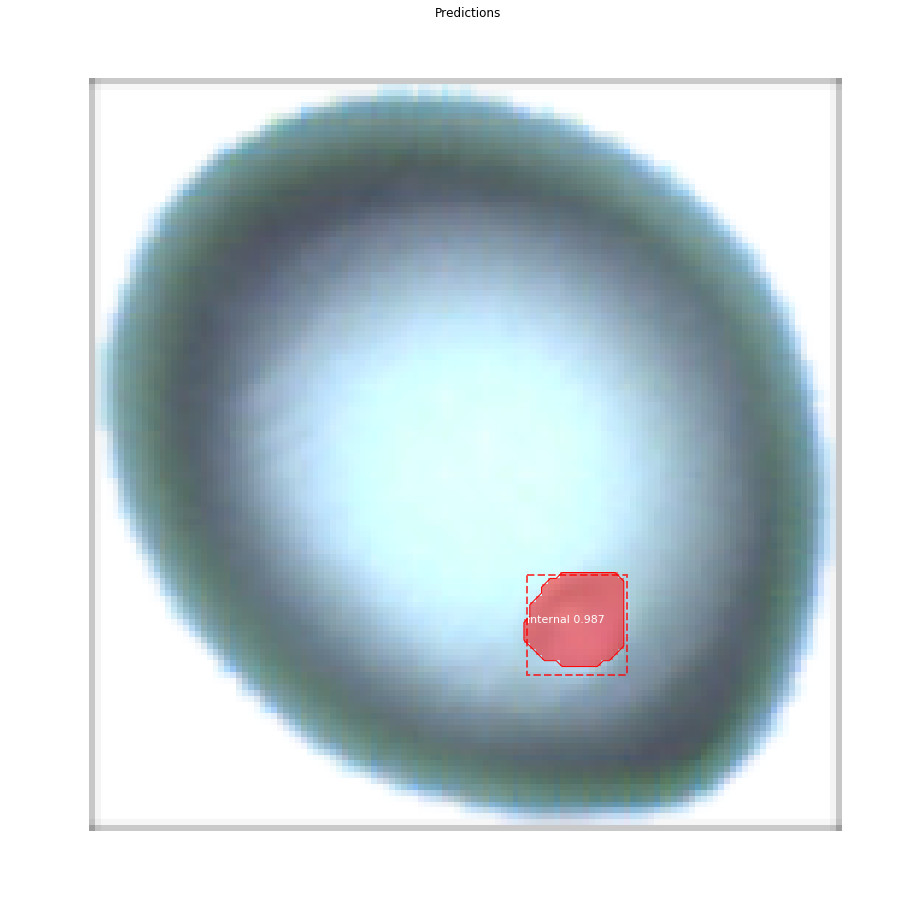

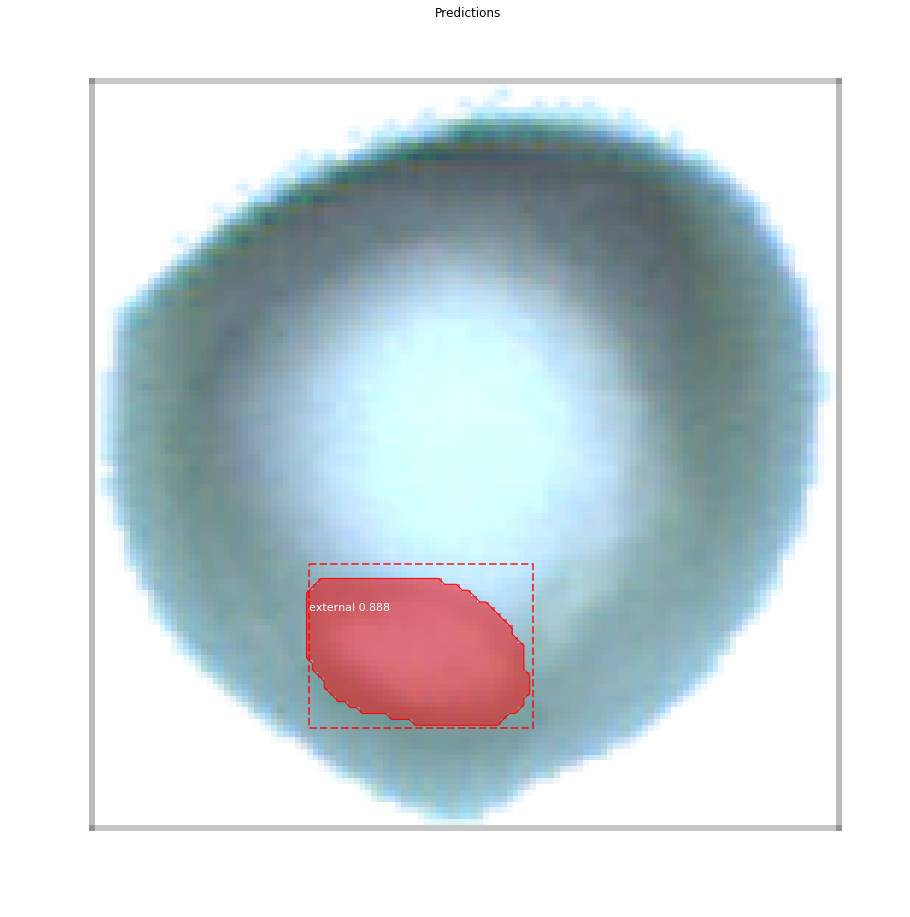

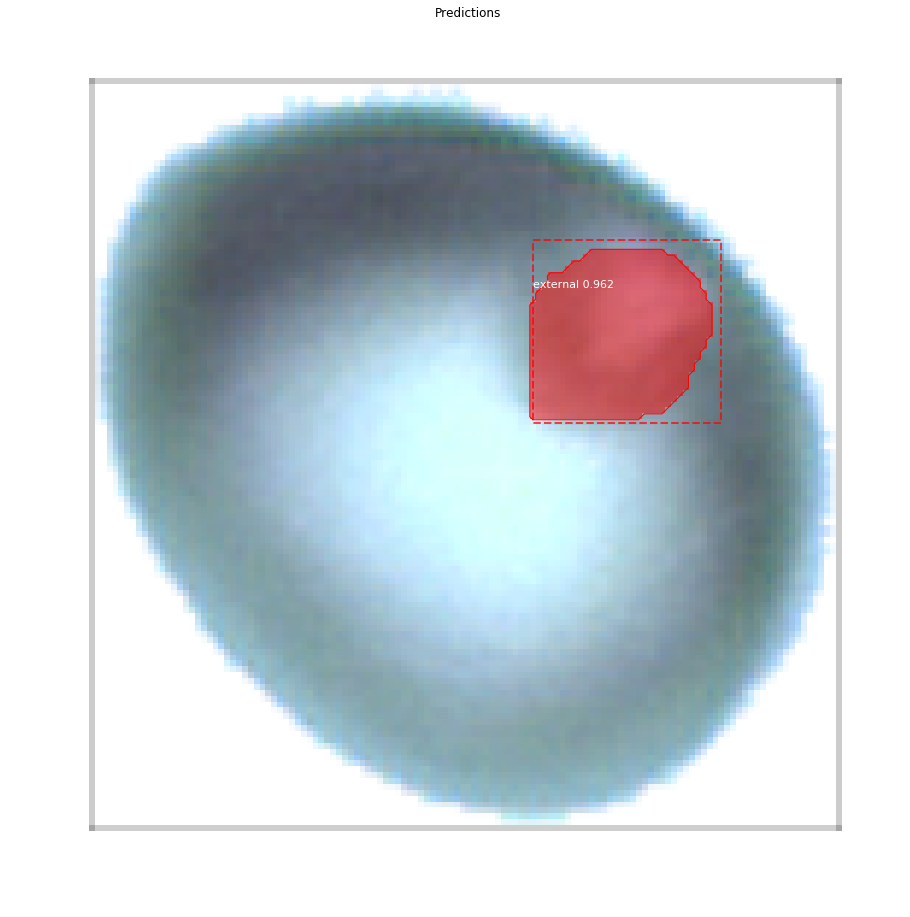

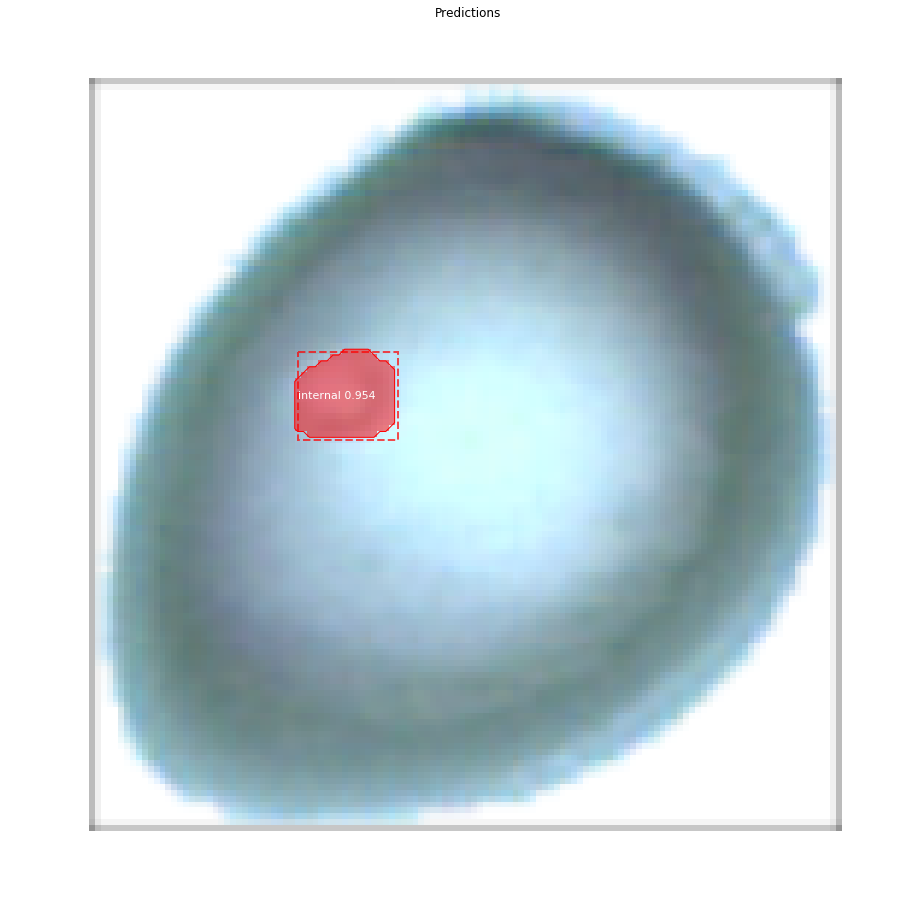

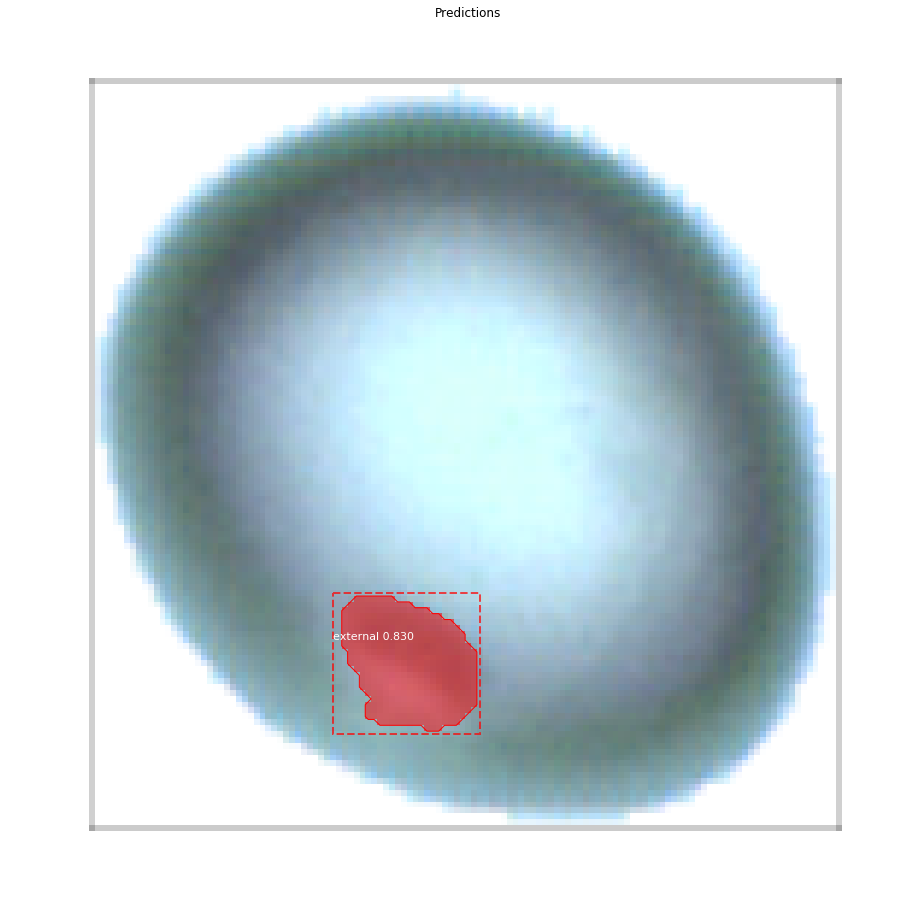

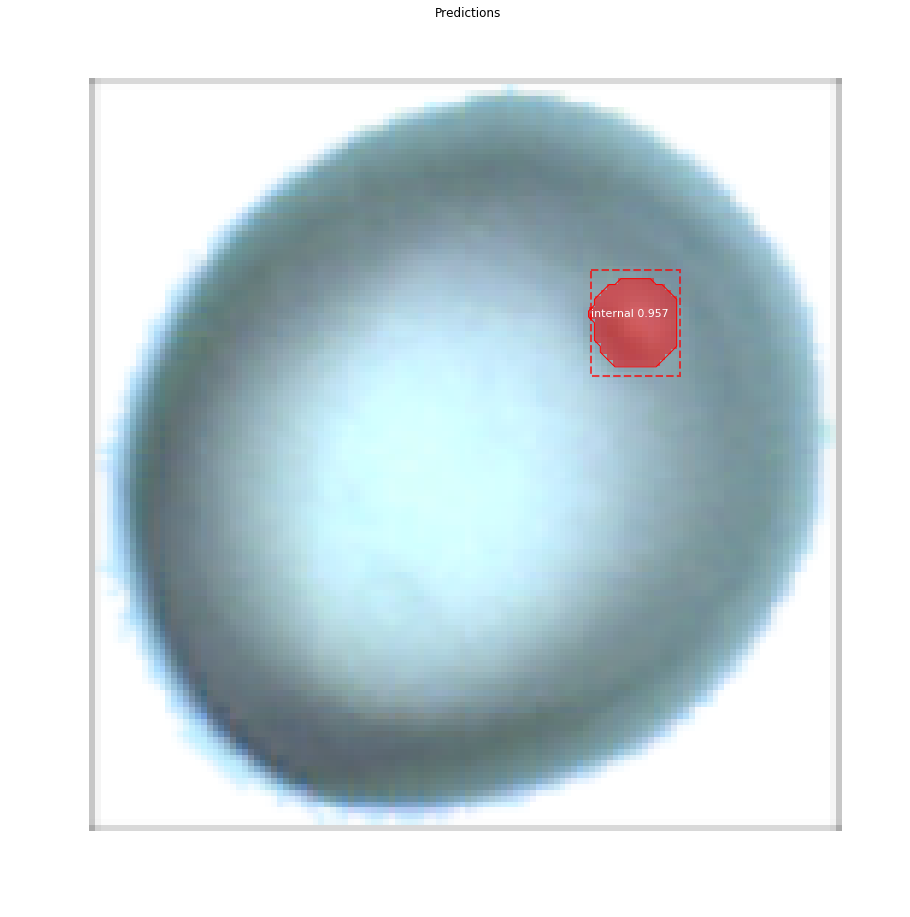

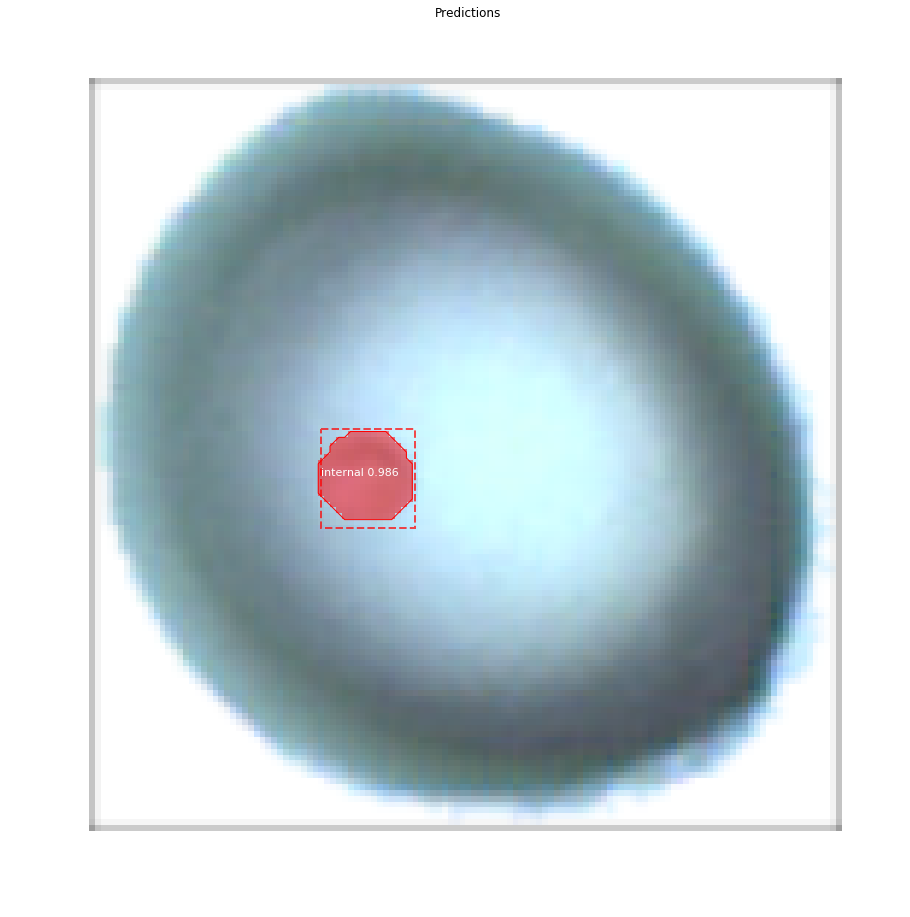

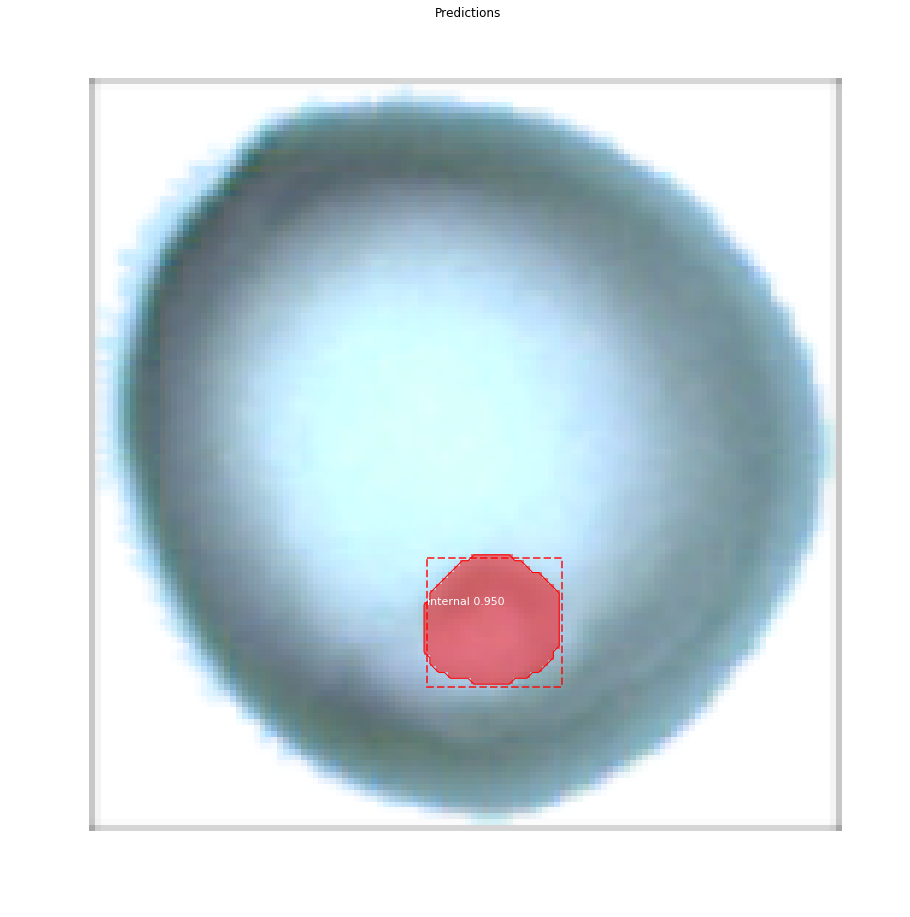

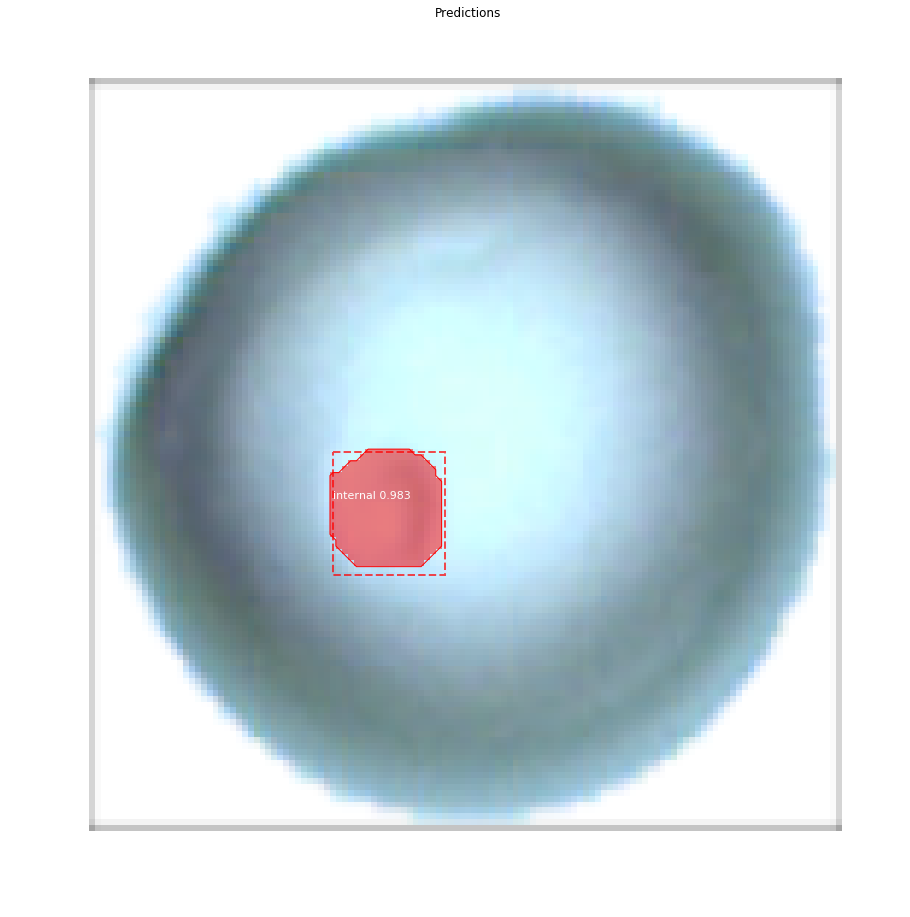

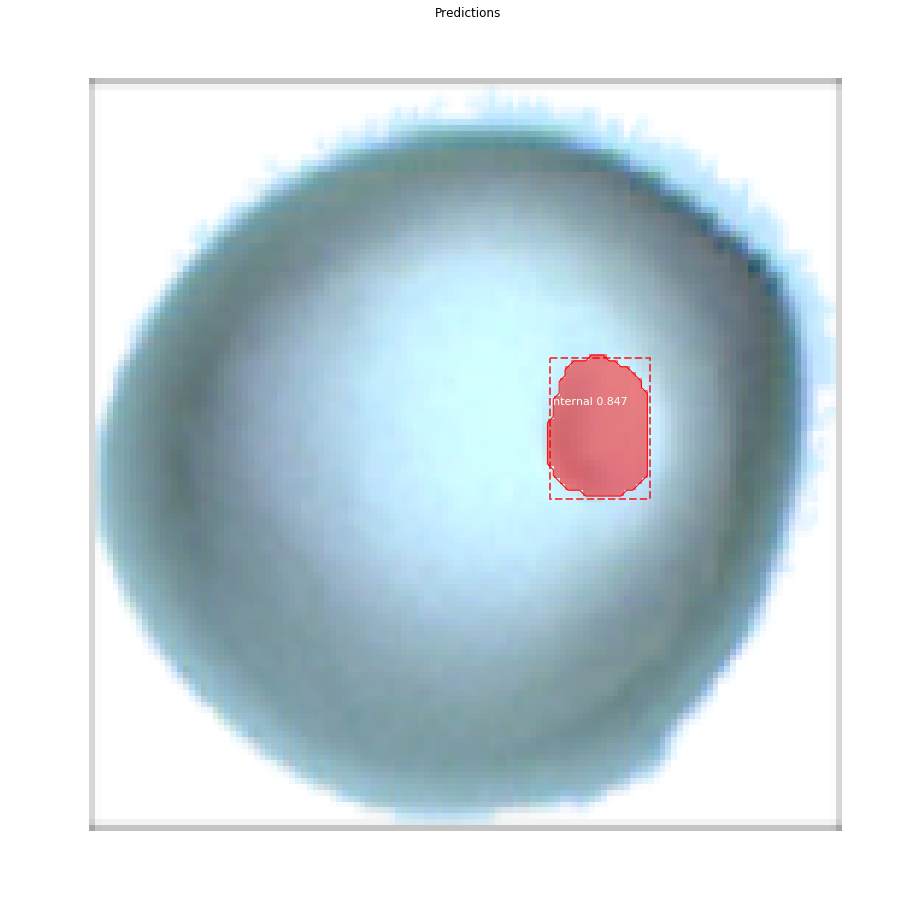

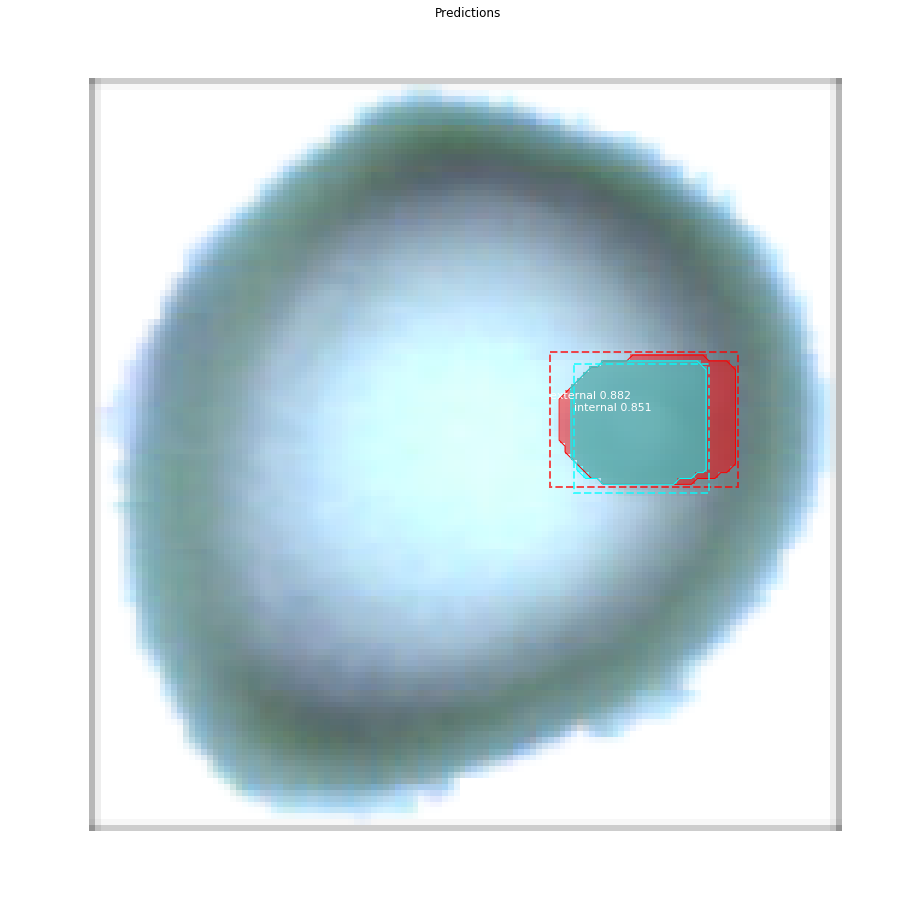

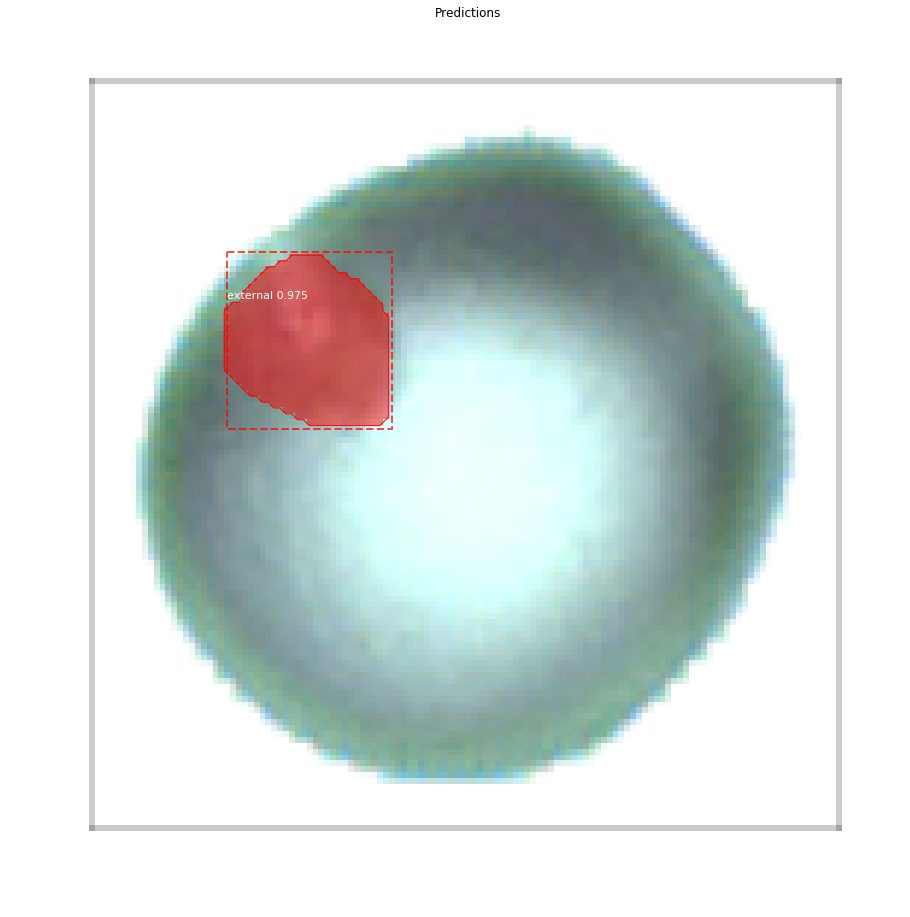

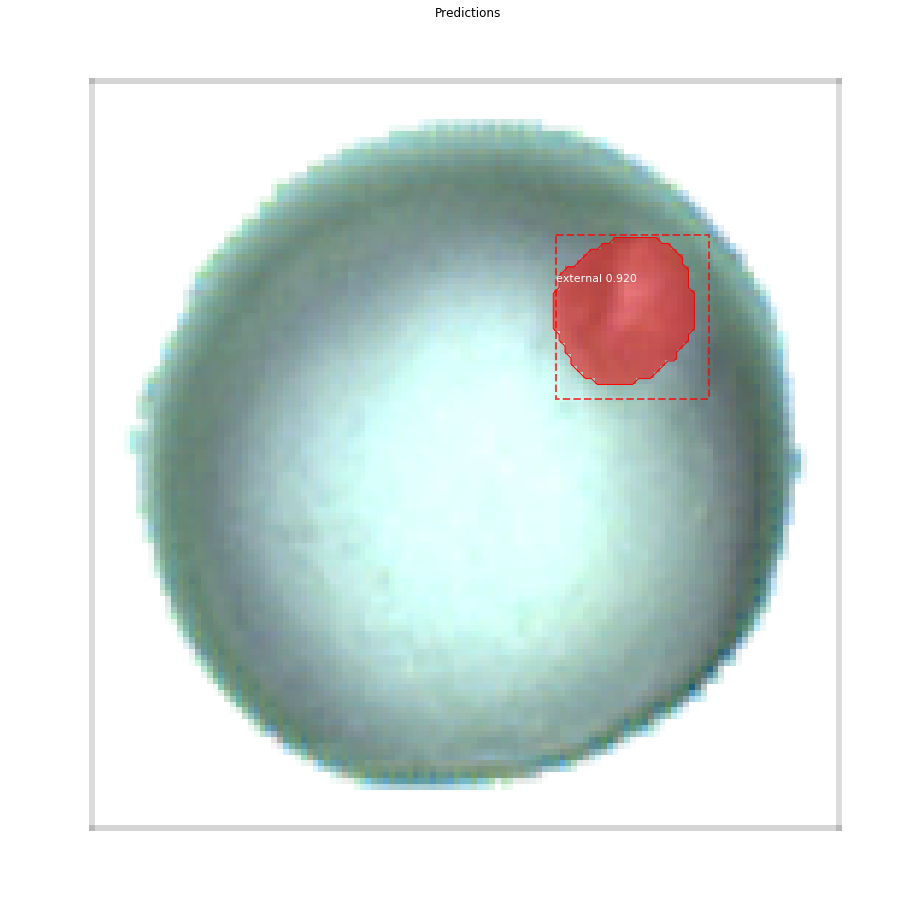

In [9]:
#image_id = random.choice(dataset.image_ids)
for image_id in dataset.image_ids:
  image, image_meta, gt_class_id, gt_bbox, gt_mask =\
      modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
  info = dataset.image_info[image_id]
  print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                         dataset.image_reference(image_id)))

  # Run object detection
  results = model.detect([image], verbose=1)

  # Display results
  ax = get_ax(1)
  r = results[0]
  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                              dataset.class_names, r['scores'], ax=ax,
                              title="Predictions")
  log("gt_class_id", gt_class_id)
  log("gt_bbox", gt_bbox)
  log("gt_mask", gt_mask)